# Table of Contents
01. Importing libraries
02. Importing data
03. Data wrangling, cleaning and consistency checks
<br>I. Missing values
<br>II. Duplicate values
<br>III. Mixed-type data
<br>IV. Data types
04. Data preprocessing
05. Utilities
06. Model
07. Run model
08. Export output file

# 01. Importing libraries

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
# Import data
train_set = pd.read_csv('../input/tabular-playground-series-sep-2022/train.csv')
test_set = pd.read_csv('../input/tabular-playground-series-sep-2022/test.csv')

In [3]:
# Check the number of rows and columns in 'train_set'
train_set.shape

(70128, 6)

In [4]:
# Check the number of rows and columns in 'test_set'
test_set.shape

(17520, 5)

In [5]:
# Display the top 5 rows from 'train_set'
pd.set_option('display.max_columns', None)
train_set.head(5)

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [6]:
# Display the top 5 rows from 'test_set'
pd.set_option('display.max_columns', None)
test_set.head(5)

,row_id,date,country,store,product
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques


# 03. Data wrangling, cleaning and consistency checks

## I. Missing values

In [7]:
# Find missing values
def missing_values(df):
    if df.isnull().sum().sum() > 0:
        return df.isnull().sum()
    else:
        print('No missing values found.')

In [8]:
# Find missing values in 'train_set'
missing_values(train_set)

No missing values found.


In [9]:
# Find missing values in 'test_set'
missing_values(test_set)

No missing values found.


## II. Duplicate values

In [10]:
# Find duplicate values
def duplicate_values(df):
    df_dups = df[df.duplicated()]
    
    if len(df_dups) > 0:
        return df_dups
    else:
        print('No duplicate values found.')

In [11]:
# Find duplicate values in 'train_set'
duplicate_values(train_set)

No duplicate values found.


In [12]:
# Find duplicate values in 'test_set'
duplicate_values(test_set)

No duplicate values found.


## III. Mixed-type data

In [13]:
# Check for mixed-type data
def mixed_type_data(df):
    i = 0
    for col in df.columns.tolist():
        weird = (df[[col]].applymap(type) != df[[col]].iloc[0].apply(type)).any(axis = 1)
        if len (df[weird]) > 0:
            print (col)
            i += 1
    
    if i == 0:
        print('No mix-type data found.')

In [14]:
# Check for mixed-type data in 'train_set'
mixed_type_data(train_set)

No mix-type data found.


In [15]:
# Check for mixed-type data in 'test_set'
mixed_type_data(test_set)

No mix-type data found.


## IV. Data types

In [16]:
# Display data types in 'train_set'
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    70128 non-null  int64 
 1   date      70128 non-null  object
 2   country   70128 non-null  object
 3   store     70128 non-null  object
 4   product   70128 non-null  object
 5   num_sold  70128 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 3.2+ MB


In [17]:
# Display data types in 'test_set'
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   row_id   17520 non-null  int64 
 1   date     17520 non-null  object
 2   country  17520 non-null  object
 3   store    17520 non-null  object
 4   product  17520 non-null  object
dtypes: int64(1), object(4)
memory usage: 684.5+ KB


# 04. Data preprocessing

In [18]:
# Create a new column in 'test_set' called 'num_sold'
test_set['num_sold'] = ''

In [19]:
# Create a dataset containing only rows for one specific country, store and product
def create_dataset(train_set, country, store, product):
    df = train_set[train_set['country'] == country]
    df =  df[df['store'] == store]
    df = df[df['product'] == product]
    
    return df

In [20]:
# Adjust dataset
def adjust_dataset(df):
    df['date'] = pd.to_datetime(df['date']) # Convert 'date' from 'object' to 'datetime'
    df = df.set_index('date') # Set 'date' as the index of the dataframe
    
    df.drop(['row_id', 'country', 'store', 'product'], axis = 1, inplace = True)
    df.reset_index(inplace=True)
    df.drop('date', axis = 1, inplace = True)
    
    return df

In [21]:
# Create training set and validation set
def train_valid_set(df, split_percentage):
    time = np.array(df.index)
    series = df['num_sold'].values
    split_time = round(split_percentage * len(time)) # Define the split time
    
    # Get the train set
    time_train = time[:split_time]
    x_train = series[:split_time]

    # Get the validation set
    time_valid = time[split_time:]
    x_valid = series[split_time:]
        
    return split_time, time, series, time_train, x_train, time_valid, x_valid 

In [22]:
# Create windowed dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

# 05. Utilities

In [23]:
# Define a function to plot graphs
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
        plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [24]:
# Define a forecast function
def model_forecast(model, series, window_size, batch_size):

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

In [25]:
# Generate predictions
def forecast(model, series, window_size, batch_size, df, split_time, split_percentage, time_valid, x_valid, values_to_predict):
    if split_percentage < 1:
        # Reduce the original series
        forecast_series = series[split_time-window_size:-1]
    else:
        forecast_series = series[len(df)-window_size-values_to_predict:-1]
    
    # Use helper function to generate predictions
    predictions = model_forecast(model, forecast_series, window_size, batch_size)
    # Drop single dimensional axes
    predictions = predictions.squeeze()
    
    return predictions

In [26]:
# Add predictions into 'test_set'
def fill_test_set(test_set, country, store, product, results):
    counter = 0
    for index, row in test_set.iterrows():
        if test_set['country'][index] == country and test_set['store'][index] == store and test_set['product'][index] == product:
            test_set['num_sold'][index] = results[counter]
            counter += 1

# 06. Model

In [27]:
from keras.layers import Conv1D

# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(tf.cast(x, tf.float32), axis=-1)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

2022-09-30 00:06:40.776412: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-30 00:06:40.879158: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-30 00:06:40.880855: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-30 00:06:40.883775: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [28]:
# Set the optimizer
optimizer = tf.keras.optimizers.Adam()

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# 07. Run model

In order to assess the performance of the model, it will first be run on a subset of 'train_set' containing only data for the first country, store and product in 'train_set'.

In [29]:
# Run model on a time series relative to the first country, store and product in 'train_set'

# Parameters
window_size = 64
batch_size = 75
shuffle_buffer_size = 1000
split_percentage = 0.7
values_to_predict = 0

country = train_set['country'].unique()[0]
store = train_set['store'].unique()[0]
product= train_set['product'].unique()[0]

df = create_dataset(train_set, country, store, product)

df = adjust_dataset(df)

split_time, time, series, time_train, x_train, time_valid, x_valid = train_valid_set(df, split_percentage)

train_window = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

history = model.fit(train_window, epochs=200, verbose=0)

results = forecast(model, series, window_size, batch_size, df, split_time, split_percentage, time_valid, x_valid, values_to_predict)

2022-09-30 00:06:46.805446: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-30 00:06:48.183074: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


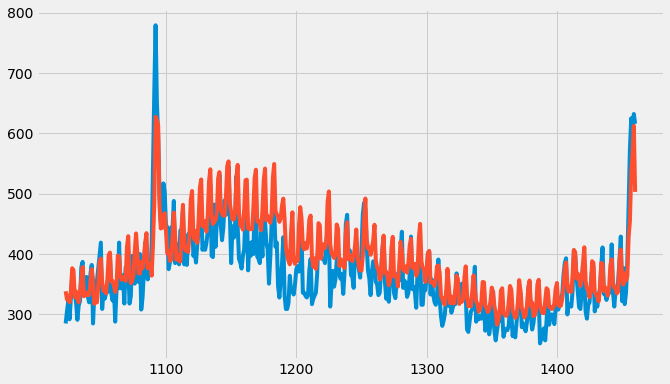

In [30]:
# Plot the results against the validation set
plot_series(time_valid, (x_valid, results))

In [31]:
## Compute the MAE and MSE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

1795.4879
32.708736


The model is deemed sufficiently accurate. Hence, the entire 'train_set' will now be fed into the neural network.

In [32]:
# Run model on entire 'train_set'

# Parameters
window_size = 64
batch_size = 75
shuffle_buffer_size = 1000
split_percentage = 1
values_to_predict = 365

for country in train_set['country'].unique():
    for store in train_set['store'].unique():
        for product in train_set['product'].unique():
            
            df = create_dataset(train_set, country, store, product)
            
            df = adjust_dataset(df)
            
            split_time, time, series, time_train, x_train, time_valid, x_valid = train_valid_set(df, split_percentage)
            
            train_window = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
            
            history = model.fit(train_window, epochs=200, verbose=0)
            
            results = forecast(model, series, window_size, batch_size, df, split_time, split_percentage, time_valid, x_valid, values_to_predict)
            
            fill_test_set(test_set, country, store, product, results)

# 08. Export output file

In [33]:
submission = test_set.copy()
submission = submission.set_index('row_id')
submission.drop(['date', 'country', 'store', 'product'], axis = 1, inplace = True)
submission.to_csv('./submission.csv')